In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from parameters import *
from dataloader import *
from model_dcgan import * 

In [2]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Create the dataloader
dataloader = get_dataset()

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Random Seed:  999


/usr/local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


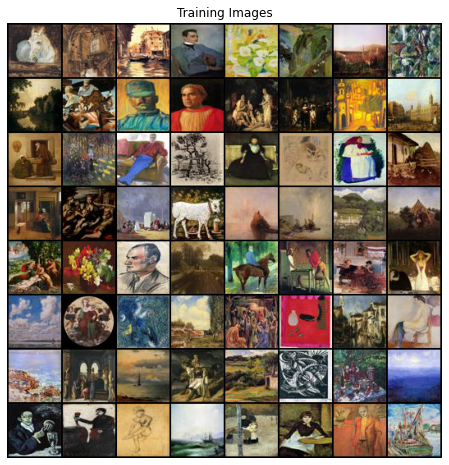

In [3]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


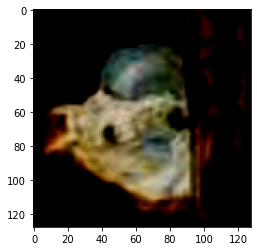

In [32]:
plt.figure(figsize=(4,4))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][0].to(device)[:64])))

In [4]:
# Create the generator
netG = Generator(ngpu).to(device)

# # Handle multi-gpu if desired
 #if device.type == 'cuda' and ngpu > 1:
#    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(150, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [5]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [64]:
from PIL import Image
from PIL import ImageEnhance
#import image_slicer
from itertools import product
import os 

filename = "imagesDCGAN/40-21000.png"
im = Image.open(filename)
from PIL import ImageFilter


#plt.figure(figsize=(70,70))
enhancer = ImageEnhance.Sharpness(im)

factor = 2
im_s_1 = enhancer.enhance(factor)
#im3 = ImageEnhance.Color(im_s_1)
#plt.figure(figsize=(50,50))
#plt.imshow(im_s_1)

#smoothenedImage = im_s_1.filter(ImageFilter.SMOOTH)
smoothenedImage = im
moreSmoothenedImage = im.filter(ImageFilter.SMOOTH_MORE)

plt.figure(figsize=(50,50))
my_dpi=20
#plt.savefig("Smoothed_GAN.png", dpi=my_dpi)
smoothenedImage.save('Smoothed_GAN.png', quality=100) 
#plt.imshow(smoothenedImage)
#M = im.shape[0]/16
#N = im.shape[1]/4
#tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]
#plt.imshow(tiles[0])
#smoothenedImage.show()dvcvreal_batch[0][0].to(device)[:64])))
#smoothenedImage.show()as adnjkhjrbfakhwjerf;ioerjFHOIw[pkefjpoweOPJJPO]
#moreSmoothenedImage.show()

def imgcrop(input, xPieces, yPieces):
    filename, file_extension = os.path.splitext(input)
    im = Image.open(input)
    imgwidth, imgheight = im.size
    height = imgheight // yPieces
    width = imgwidth // xPieces
    for i in range(0, yPieces):
        for j in range(0, xPieces):
            box = (j * width, i * height, (j + 1) * width, (i + 1) * height)
            a = im.crop(box)
            a = a.resize((250,250),Image.ANTIALIAS)
            #a= a.filter(ImageFilter.SMOOTH)
            #a= enhancer.enhance(a)
            #left = 40
            #top = 40
            #right = 2
            #bottom = 2
            #a=a.crop((left, top, right, bottom))
            #a=a.save('Smoothed_GAN.png')
            
            try:
                #a= enhancer.enhance(a)
                a.save("" + filename + "-" + str(i) + "-" + str(j) + file_extension, quality=100)
                
            except:
                pass

imgcrop("Smoothed_GAN.png", 4, 16)



<Figure size 3600x3600 with 0 Axes>

SystemError: tile cannot extend outside image

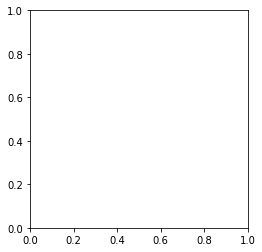

In [69]:
im=Image.open("Smoothed_GAN-13-3.png")
#factor = 2
#im_out= ImageEnhance.Color(im).enhance(factor)
#im_out = ImageEnhance.Sharpness(im).enhance(2)
#im_out = ImageEnhance.Brightness(im).enhance(1.1)
width, height = im.size
left = 0
top = 0
right = 0
bottom = 0
im3=im.crop((left, top, right, bottom))
plt.imshow(im3)
#plt.figure(figsize=(5,5))
#plt.imshow(im_out)
#plt.savefig("trial.png", dpi=250)


#import glob 
#image_list=[]
#for filename in glob.glob('smoothedgan/*.png'): #assuming gif
    #im=Image.open(filename)
    #factor = 2
   # im_out= ImageEnhance.Color(im).enhance(factor)
    
    #try:
        #im_out.save("new" + filename , quality=100)
    #except:
        #pass
    
    #image_list.append(im)

#for image in image_list:
    #image = Image.open(image)
    #factor = 2
    #im_s_1 = image.enhance(factor)
    #im3 = ImageEnhance.Color(im_s_1)
    #image=im3
    #image.write(image)
    #image= ImageEnhance.Color(image).enhance(factor)
    #image= enhancer.enhance(image)
    #image.write(image)



In [63]:
# Training Loop
from torchvision.utils import save_image
img_save_path = 'imagesDCGAN2'
img_save_path2 = 'imagesDCGAN2_individual_'
#os.makedirs("images", exist_ok=True)
os.makedirs(img_save_path, exist_ok=True)
os.makedirs(img_save_path2, exist_ok=True)
example_size = 4

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=0, normalize=True))
            save_image(fake.data, img_save_path + '/%d-%d.png' % (epoch,iters), nrow=example_size, normalize=True)
            #print(fake.data)
            #save_image(fake.data[0][0], img_save_path2 + '/%d-%d.png' % (epoch,iters))

        
                    
            save_image(vutils.make_grid(fake[0][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d01.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[0][1].to(device)[:64], padding=0, normalize=True), img_save_path2 + '/%d-%d02.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[0][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d03.png' % (epoch,iters))
            #save_image(vutils.make_grid(fake[0][3].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d04.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[1][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d11.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[1][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d12.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[1][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d13.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[2][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d21.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[2][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d22.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[2][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d23.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[3][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d31.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[3][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d32.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[3][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d33.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[4][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d41.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[4][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d42.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[4][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d43.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[5][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d51.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[5][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d52.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[5][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d53.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[6][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d61.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[6][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d62.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[6][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d63.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[7][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d71.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[7][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d72.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[7][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d73.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[8][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d81.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[8][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d82.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[8][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d83.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[9][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d91.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[9][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d92.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[9][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d93.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[10][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d101.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[10][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d102.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[10][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d103.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[11][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d111.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[11][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d112.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[11][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d113.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[12][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d121.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[12][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d122.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[12][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d123.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[13][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d131.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[13][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d132.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[13][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d133.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[14][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d141.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[14][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d142.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[14][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d143.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[15][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d151.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[15][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d152.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[15][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d153.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[16][0].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d161.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[16][1].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d162.png' % (epoch,iters))
            save_image(vutils.make_grid(fake[16][2].to(device)[:64],padding=0, normalize=True), img_save_path2 + '/%d-%d163.png' % (epoch,iters))




        iters += 1



Starting Training Loop...


/usr/local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1111d4700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/Cellar/python@3.9/3.9.6/Frameworks/Python.framework/V

KeyboardInterrupt: 

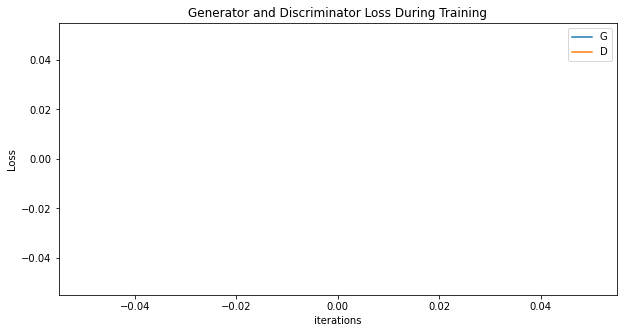

In [64]:
# Plot Losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [1]:
print(img_list[0])

NameError: name 'img_list' is not defined

In [ ]:
# Visualize G's Progress
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Real vs Fake
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()